Prepare the data:

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch.optim as optim
import torchvision.datasets as datasets
from torch.autograd import Variable
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.pyplot import imshow
#from torchsummary import summary

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
torch.cuda.is_available()

cuda:0


True

In [6]:
class CIFAR10RandomLabels(datasets.CIFAR10):
    """CIFAR10 dataset, with support for randomly corrupt labels.
    Params
    ------  
    corrupt_prob: float
    Default 0.0. The probability of a label being replaced with
    random label.
    num_classes: int
    Default 10. The number of classes in the dataset.
    """
    def __init__(self, corrupt_prob=0.0, num_classes=10, **kwargs):
        super(CIFAR10RandomLabels, self).__init__(**kwargs)
        self.n_classes = num_classes
        if corrupt_prob > 0:
            self.corrupt_labels(corrupt_prob)

    def corrupt_labels(self, corrupt_prob):
        labels = np.array(self.targets)
        np.random.seed(12345)
        mask = np.random.rand(len(labels)) <= corrupt_prob
        rnd_labels = np.random.choice(self.n_classes, mask.sum())
        labels[mask] = rnd_labels
        # we need to explicitly cast the labels from npy.int64 to
        # builtin int type, otherwise pytorch will fail...
        labels = [int(x) for x in labels]
        self.targets = torch.tensor(labels)

In [54]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainloader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=True, download=True, 
                            transform=transform, corrupt_prob=0),
                            batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(
        CIFAR10RandomLabels(root='./data', train=False, download=True,
                            transform=transform, corrupt_prob=0),
                            batch_size=10000, shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def prune(self, threshold):
        # generate mask
        for params in self.parameters():
            if len(params.data.size()) != 1: # Not bias
                mask = params.data.abs() > threshold
                self.set_mask(mask.float()) 
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.linear(x, weight, self.bias)
        else:
            return F.linear(x, self.weight, self.bias)
        

        
class MaskedConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, 
            kernel_size, stride, padding, dilation, groups, bias)
        self.mask_flag = False
    
    def set_mask(self, mask):
        self.mask = Variable(mask, requires_grad=False)
        self.weight.data = self.weight.data*self.mask.data
        self.mask_flag = True
    
    def get_mask(self):
        print(self.mask_flag)
        return self.mask
    
    def prune(self, threshold):
        # generate mask
        for params in self.parameters():
            if len(params.data.size()) != 1: # Not bias
                mask = params.data.abs() > threshold
                self.set_mask(mask.float()) 
    
    def forward(self, x):
        if self.mask_flag == True:
            weight = self.weight*self.mask
            return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)
        else:
            return F.conv2d(x, self.weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

Define the network:

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        linear = MaskedLinear
        conv2d = MaskedConv2d
        self.conv1 = conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = conv2d(6, 16, 5)
        self.fc1 = linear(16 * 5 * 5, 240)
        self.fc2 = linear(240, 84)
        self.fc3 = linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        out_SNE = F.relu(self.fc2(x))
        x = self.fc3(out_SNE)
        return out_SNE, x
    
    def weight_prune(self, pruning_perc):
        all_weights = []
        for params in self.parameters():
            if len(params.data.size()) != 1:
                all_weights += list(params.cpu().data.abs().numpy().flatten())
        threshold = np.percentile(np.array(all_weights), pruning_perc)
        print(f'Pruning with threshold : %.4f' % threshold)
        
        # Module here refers to layer
        for name, module in self.named_modules():
            if name in ['conv1','conv2','fc1','fc2','fc3','fc4']:
                module.prune(threshold)                

net = Net()
net.to(device)
#summary(net, (3, 32, 32))

Net(
  (conv1): MaskedConv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): MaskedConv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): MaskedLinear(in_features=400, out_features=240, bias=True)
  (fc2): MaskedLinear(in_features=240, out_features=84, bias=True)
  (fc3): MaskedLinear(in_features=84, out_features=10, bias=True)
)

In [10]:
def train(model, optimizer, epochs, early_stop_step=0):
    step_counter = 0
    best_accuracy = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
      
        train_correct = 0
        train_total = 0
        running_loss = 0.0
        train_accuracy = 0.0
        
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
    
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output_SNE, outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
             #   print('[%d, %5d] loss: %.3f' %
             #         (epoch + 1, i + 1, running_loss / 100))
                train_loss = running_loss / 100
                running_loss = 0.0

        if epoch % 10 == 9:     
            with torch.no_grad():
                for data in trainloader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    output_SNE, outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    train_total += labels.size(0)
                    train_correct += (predicted == labels).sum().item()
                    
            train_accuracy = 100 * train_correct / train_total
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, train_loss))
            print('Train Accuracy: %.3f %%' % train_accuracy)
            
        '''
        if early_stop_step != 0:
            step_counter += 1
            if best_accuracy < train_accuracy:
                best_accuracy = train_accuracy
                step_counter = 0
            if step_counter == early_stop_step or epoch == epochs - 1:
                print("Early stop at epoch %d" % (epoch + 1))
                print('Train Accuracy: %.3f %%, Train Loss: %.3f' % (train_accuracy, train_loss))
                break
        '''
        
        if train_accuracy - 100.0 < 0.001 and train_loss - 0.0 < 0.001:
            print("Reach 100 %% train accuracy at epoch %d" % (epoch + 1))
            break
            
    #print('Finished Training')

In [11]:
def test(model):
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)
            out_SNE, outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += criterion(outputs, labels).item()
    
    #print('Test Accuracy on 10000 images: %.2f %%' % (
    #    100 * correct / total))
    
    # test loss for 100 mini-batches)
    print('Test Accuracy: %.3f %%, Test Loss: %.3f' % (100 * correct / total, test_loss / 100))

In [12]:
def calculate_size(model):
    non_zeros = 0
    for param in model.parameters():
        if param.requires_grad==True:
            non_zeros += param.nonzero().size(0)
    params_size = non_zeros* 4. / (1024 ** 2)
    print("Params size (MB): %0.3f" % params_size)

In [13]:
criterion = nn.CrossEntropyLoss() # Softmax is built in it so you do not need add that on the last layer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#initial_optimizer_state_dict = optimizer.state_dict()
train(net, optimizer, 100)
model_path = "models/LeNet_tSNE.pt"
torch.save(net.state_dict(), model_path)
test(net)
calculate_size(net)

[10,   391] loss: 1.610
Train Accuracy: 42.658 %
[20,   391] loss: 1.284
Train Accuracy: 55.080 %
[30,   391] loss: 1.117
Train Accuracy: 61.030 %
[40,   391] loss: 0.987
Train Accuracy: 65.952 %
[50,   391] loss: 0.888
Train Accuracy: 70.350 %
[60,   391] loss: 0.774
Train Accuracy: 72.692 %
[70,   391] loss: 0.684
Train Accuracy: 78.392 %
[80,   391] loss: 0.578
Train Accuracy: 82.006 %
[90,   391] loss: 0.468
Train Accuracy: 85.168 %
[100,   391] loss: 0.400
Train Accuracy: 88.976 %
Test Accuracy: 63.200 %, Test Loss: 0.014
Params size (MB): 0.459


In [73]:
net.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to("cpu"), data[1].to("cpu")
        output_SNE, outputs = net(images)
        tsne = TSNE(learning_rate=50).fit_transform(output_SNE.numpy())
        tx, ty = tsne[:,0], tsne[:,1]

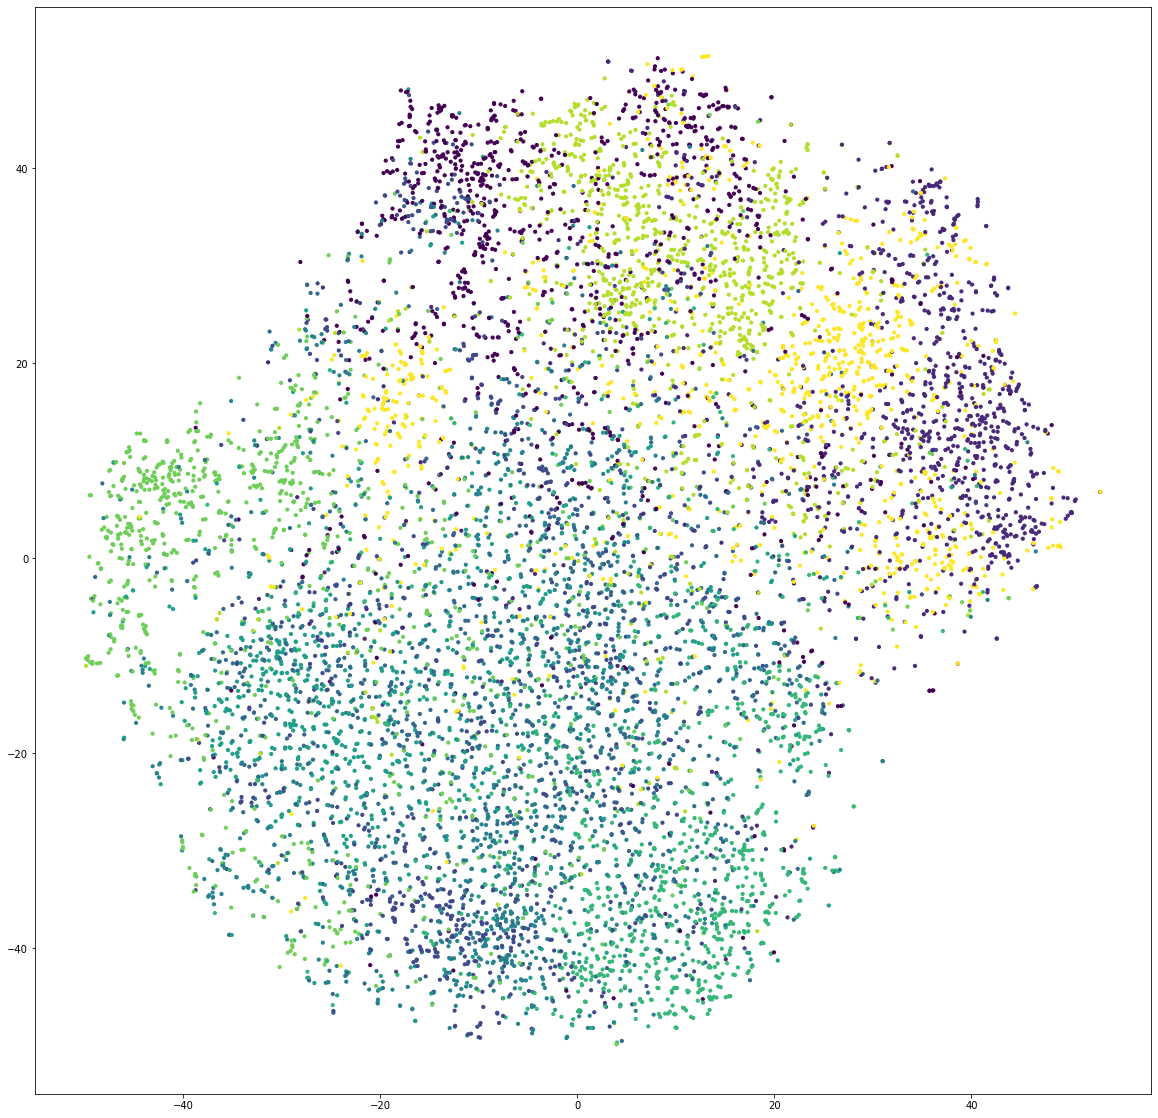

In [74]:
plt.rcParams["figure.figsize"] = (20,20)
plt.scatter(tx, ty, 10, labels)

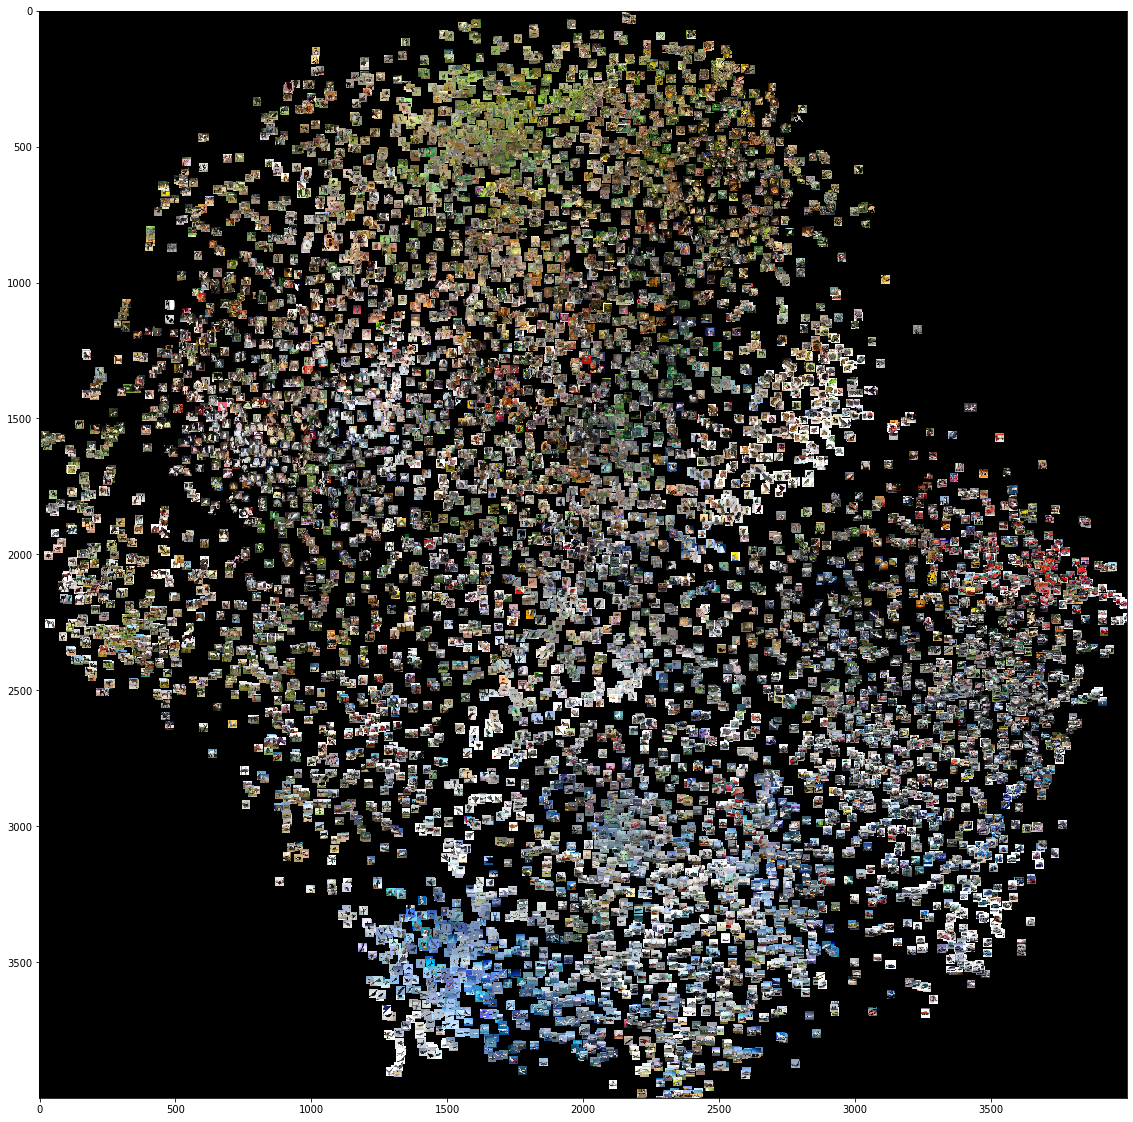

In [76]:
width = 4000
height = 4000
max_dim = 32
full_image = Image.new('RGB', (width, height))

for i in range(0, 10000):
    img = (images[i].numpy() / 2 + 0.5)* 255
    img = np.moveaxis(img, 0, -1)
    tile = Image.fromarray(img.astype('uint8'), mode='RGB')
    rs = max(1, tile.width / max_dim, tile.height / max_dim)
    tile = tile.resize((int(tile.width / rs),
                       int(tile.height / rs)),
                       Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim) * (tx[i]/100+0.5)),
                            int((height-max_dim) * (ty[i]/100+0.5))))
    
imshow(np.asarray(full_image))

In [77]:
full_image.show()